In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf-
import statsmodels.api as sm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import os
import scipy.stats as stats

In [ ]:
# --- Step 1: Setup and Data Loading ---
DATA_FILE = '/root/autodl-tmp/ndx_data.csv' 

SEQUENCE_LENGTH = 252 

BATCH_SIZE = 64
LR = 0.0001
EPOCHS = 5000 

# WGAN-GP specific parameters
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

# Model architecture parameters
NOISE_DIM = 100
HIDDEN_DIM = 128
NUM_SAMPLES_TO_GENERATE = 1000

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Check and load data
if not os.path.exists(DATA_FILE):
    print(f"Error: data file '{DATA_FILE}' not found!")
    exit()

print(f"Loading data from local file: {DATA_FILE}")
data = pd.read_csv(DATA_FILE, index_col='Date', parse_dates=True)

print(f"Original data contains {len(data)} days.")
data = data.loc['2014-01-01':'2018-12-31']
print(f"Kept only the first 5 years of data (2014-2018); {len(data)} days remain for quick testing.")

Loading data from local file: /root/autodl-tmp/ndx_data.csv
Original data contains 2767 days.
Kept only the first 5 years of data (2014-2018); 1258 days remain for quick testing.


In [ ]:
# --- Step 2: Data preprocessing ---
log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna().values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(log_returns)

sequences = []
for i in range(len(data_normalized) - SEQUENCE_LENGTH):
    sequences.append(data_normalized[i:i+SEQUENCE_LENGTH])

print(f"Data loaded, created {len(sequences)} training samples.")
real_sequences = torch.FloatTensor(np.array(sequences)).to(device)
dataset = TensorDataset(real_sequences)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Data loaded, created 1005 training samples.


In [6]:
# --- Step 3: Build the model (use the correct LSTM architecture) ---
# 3.1 LSTM Generator
class LSTMGenerator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, output_dim=1):
        super(LSTMGenerator, self).__init__()
        self.lstm = nn.LSTM(input_size=noise_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out)
        return torch.tanh(out) # Use Tanh to match MinMaxScaler

# 3.2 LSTM Discriminator (Critic)
class LSTMCritic(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128):
        super(LSTMCritic, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.linear(hidden.squeeze(0))
        return out

In [ ]:
# --- Step 4: Implement gradient penalty function (CuDNN issue fixed) ---
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.randn(real_samples.size(0), 1, 1, device=device).expand_as(real_samples)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    with torch.backends.cudnn.flags(enabled=False):
        interpolated_scores = critic(interpolated)
    
    gradients = torch.autograd.grad(
        outputs=interpolated_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

In [8]:
# --- Step 5: Model training ---
generator = LSTMGenerator(noise_dim=NOISE_DIM, hidden_dim=HIDDEN_DIM).to(device)
critic = LSTMCritic(hidden_dim=HIDDEN_DIM).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.0, 0.9))
optimizer_c = torch.optim.Adam(critic.parameters(), lr=LR, betas=(0.0, 0.9))

print("\nStart WGAN-GP training (LSTM architecture, 5 years of data)...")
for epoch in range(EPOCHS):
    for i, (real_seqs,) in enumerate(dataloader):
        current_batch_size = real_seqs.size(0)
        # --- Train Critic ---
        for _ in range(CRITIC_ITERATIONS):
            optimizer_c.zero_grad()
            noise = torch.randn(current_batch_size, SEQUENCE_LENGTH, NOISE_DIM, device=device)
            fake_seqs = generator(noise).detach()
            real_scores = critic(real_seqs)
            fake_scores = critic(fake_seqs)
            gradient_penalty = compute_gradient_penalty(critic, real_seqs, fake_seqs)
            c_loss = fake_scores.mean() - real_scores.mean() + LAMBDA_GP * gradient_penalty
            c_loss.backward()
            optimizer_c.step()
        
        # --- Train Generator ---
        optimizer_g.zero_grad()
        noise = torch.randn(current_batch_size, SEQUENCE_LENGTH, NOISE_DIM, device=device)
        fake_seqs = generator(noise)
        fake_scores = critic(fake_seqs)
        g_loss = -fake_scores.mean()
        g_loss.backward()
        optimizer_g.step()

    if (epoch + 1) % 500 == 0: # Print more frequently
        print(f"[Epoch {epoch+1}/{EPOCHS}] [Critic loss: {c_loss.item():.4f}] [Generator loss: {g_loss.item():.4f}]")
print("Training finished.\n")


Start WGAN-GP training (LSTM architecture, 5 years of data)...


/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch 500/5000] [Critic loss: -0.3861] [Generator loss: 2.3502]
[Epoch 1000/5000] [Critic loss: -0.9248] [Generator loss: 2.0212]
[Epoch 1500/5000] [Critic loss: -1.2796] [Generator loss: 2.5545]
[Epoch 2000/5000] [Critic loss: -1.8093] [Generator loss: 2.6156]
[Epoch 2500/5000] [Critic loss: -1.6592] [Generator loss: 2.9934]
[Epoch 3000/5000] [Critic loss: -1.8137] [Generator loss: 3.4262]
[Epoch 3500/5000] [Critic loss: -2.0815] [Generator loss: 3.9221]
[Epoch 4000/5000] [Critic loss: -2.2523] [Generator loss: 4.2972]
[Epoch 4500/5000] [Critic loss: -2.3870] [Generator loss: 4.2423]
[Epoch 5000/5000] [Critic loss: -2.4522] [Generator loss: 5.2663]
Training finished.



In [ ]:
# --- Step 6: Evaluation and visualization of results ---
print("Generating samples and running evaluation...")
generator.eval()
with torch.no_grad():
    noise = torch.randn(NUM_SAMPLES_TO_GENERATE, SEQUENCE_LENGTH, NOISE_DIM, device=device)
    generated_normalized = generator(noise).cpu().numpy()

generated_returns = scaler.inverse_transform(generated_normalized.reshape(-1, SEQUENCE_LENGTH))
real_returns_flat = scaler.inverse_transform(real_sequences.cpu().numpy().reshape(-1, SEQUENCE_LENGTH)).flatten()
generated_returns_flat = generated_returns.flatten()

# Visualization code
plt.style.use('seaborn-v0_8-whitegrid')

Generating samples and running evaluation...


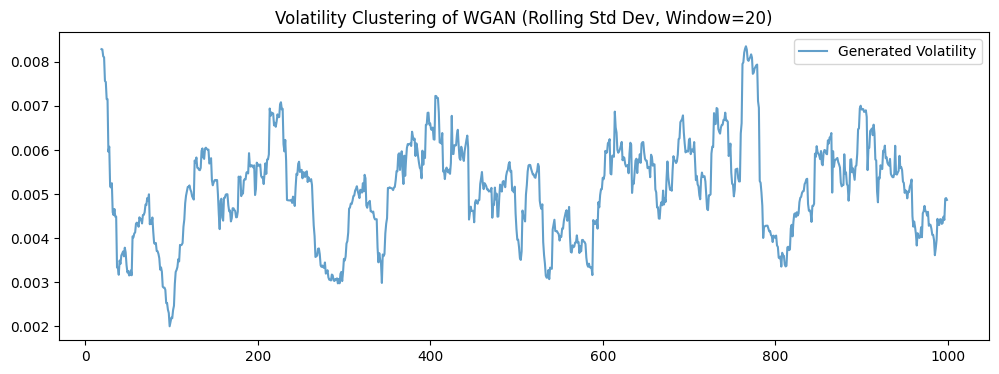

In [105]:
# Volatility Clustering
volatility_fake = pd.Series(generated_returns_flat).rolling(window=20).std()

plt.figure(figsize=(12, 4))
plt.plot(volatility_fake[:1000], label='Generated Volatility', alpha=0.7)
plt.title('Volatility Clustering of WGAN (Rolling Std Dev, Window=20)')
plt.legend()
plt.show()

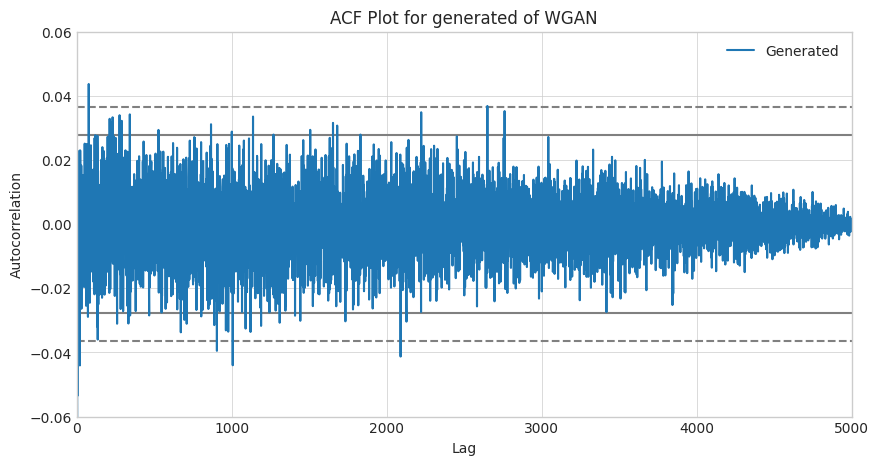

In [60]:
# ACF
plt.figure(figsize=(10, 5))

pd.plotting.autocorrelation_plot(generated_returns_flat[:5000], label='Generated')
plt.title('ACF Plot for generated of WGAN') 
plt.xlim([0, 5000])
plt.ylim([-0.06, 0.06]) 
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

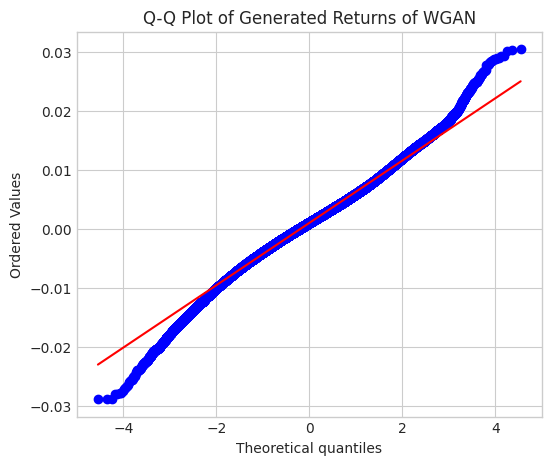

In [59]:
# Q-Q Plot
plt.figure(figsize=(6, 5))
stats.probplot(generated_returns_flat, dist="norm", plot=plt)
plt.title('Q-Q Plot of Generated Returns of WGAN')
plt.show()

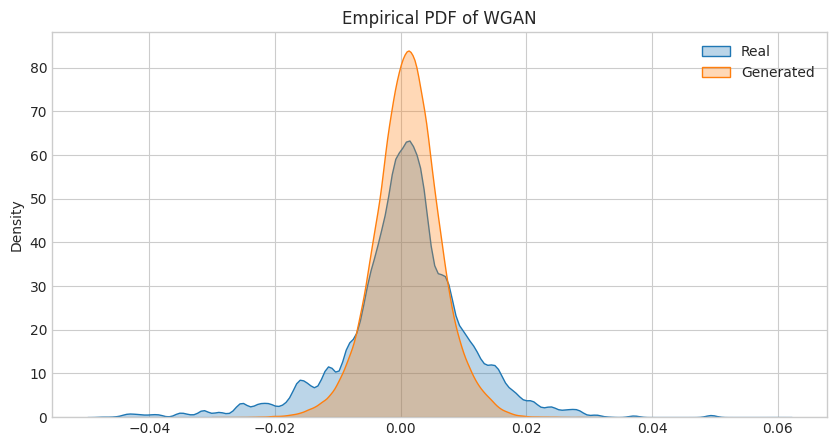

In [58]:
# KDE 
plt.figure(figsize=(10, 5))
sns.kdeplot(real_returns_flat, label='Real', fill=True, alpha=0.3)
sns.kdeplot(generated_returns_flat, label='Generated', fill=True, alpha=0.3)
plt.title('Empirical PDF of WGAN')
plt.legend()
plt.show()

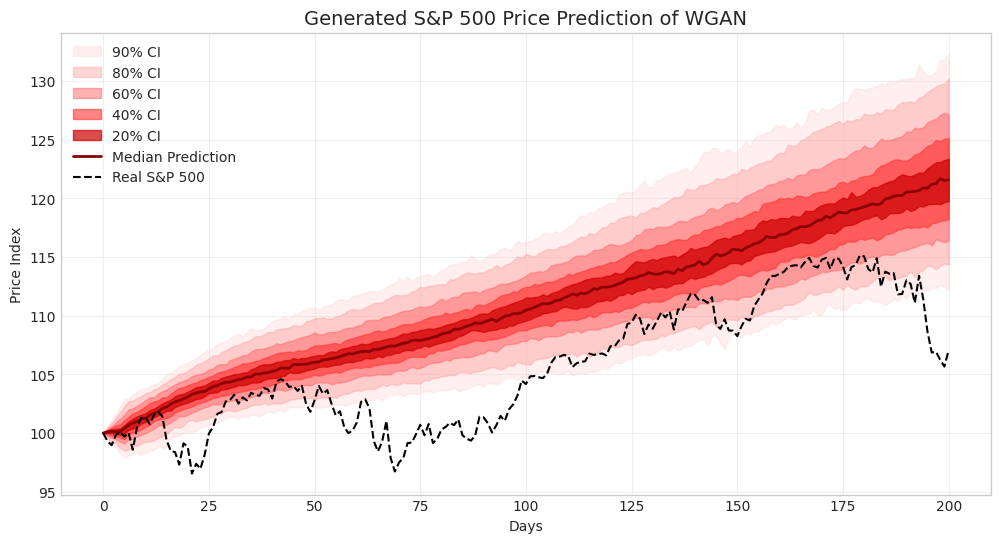

In [102]:
real_ret = real_returns_flat 
netG = generator
seq_len = SEQUENCE_LENGTH
noise_dim = NOISE_DIM
dev = device
s_scaler = scaler

S0 = 100

def returns_to_index(returns, start_price):
    cumulative_returns = np.cumsum(returns)
    cumulative_returns = np.clip(cumulative_returns, -20, 20)
    index = start_price * np.exp(cumulative_returns)
    return np.insert(index, 0, start_price)

real_price = returns_to_index(real_ret, S0)

n_sims = 300
sim_returns = []
sim_prices = []
target_len = 200

netG.eval()
with torch.no_grad():
    for _ in range(n_sims):
        z = torch.randn(1, target_len, noise_dim, device=dev)
        fake_norm = netG(z).cpu().numpy().reshape(-1, 1)
        fake_r = s_scaler.inverse_transform(fake_norm).flatten()
        
        sim_returns.append(fake_r)
        sim_prices.append(returns_to_index(fake_r, S0))

sim_returns = np.array(sim_returns)
sim_prices = np.array(sim_prices)

percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
fan_data = np.percentile(sim_prices, percentiles, axis=0)
median_path = fan_data[5]

# Fan Chart (S&P 500 Price)
plt.figure(figsize=(12, 6))
x = range(len(median_path))

# 90% CI (5-95)
plt.fill_between(x, fan_data[0], fan_data[10], color='#ffcccc', alpha=0.3, label='90% CI')
# 80% CI (10-90)
plt.fill_between(x, fan_data[1], fan_data[9], color='#ff9999', alpha=0.4, label='80% CI')
# 60% CI (20-80)
plt.fill_between(x, fan_data[2], fan_data[8], color='#ff6666', alpha=0.5, label='60% CI')
# 40% CI (30-70)
plt.fill_between(x, fan_data[3], fan_data[7], color='#ff3333', alpha=0.6, label='40% CI')
# 20% CI (40-60)
plt.fill_between(x, fan_data[4], fan_data[6], color='#cc0000', alpha=0.7, label='20% CI')
# midean
plt.plot(x, median_path, color='darkred', linewidth=2, label='Median Prediction')
plt.plot(x, real_price[:len(x)], color='black', linewidth=1.5, linestyle='--', label='Real S&P 500')
plt.title("Generated S&P 500 Price Prediction of WGAN", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Price Index")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

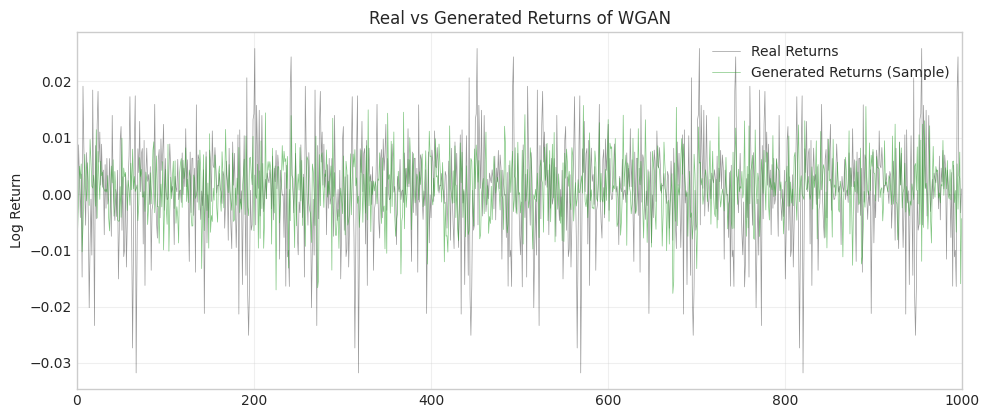

In [98]:
# Price Plot
plt.figure(figsize=(10, 8))
# plt.subplot(2, 1, 1)

# real_len = min(len(real_price), target_len)
# plt.plot(real_price[:real_len], label='Real S&P 500 Price', color='black', alpha=0.7)
# plt.fill_between(x, fan_data[0], fan_data[10], color='#ffcccc', alpha=0.3, label='90% CI')
# plt.fill_between(x, fan_data[2], fan_data[8], color='#ff6666', alpha=0.5, label='60% CI')
# plt.plot(x, median_path, color='darkred', linewidth=1.5, label='Median Prediction')
# plt.title(f"Real vs Generated Price (Length={target_len})", fontsize=12)
# plt.ylabel("Price Index")
# plt.xlim([0, target_len]) 
# plt.legend(loc='upper left')
# plt.grid(True, alpha=0.3)

# Return Plot
plt.subplot(2, 1, 2)

sample_ret = sim_returns[0] 
real_ret_len = min(len(real_ret), target_len)
plt.plot(real_ret[:real_ret_len], label='Real Returns', color='black', alpha=0.4, linewidth=0.5)
plt.plot(sample_ret, label='Generated Returns (Sample)', color='#2ca02c', alpha=0.6, linewidth=0.5)
plt.title(f"Real vs Generated Returns of WGAN", fontsize=12)
plt.ylabel("Log Return")
plt.xlim([0, target_len])
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
real_stats = pd.Series(real_returns_flat, name="Real").describe()
wgan_stats = pd.Series(generated_returns_flat, name="WGAN").describe()
comparison_table = pd.concat([real_stats, wgan_stats], axis=1)
display(comparison_table)
# wgan_stats = pd.Series(generated_returns_flat, name="WGAN").describe()
# display(wgan_stats.to_frame())

,Real,WGAN
count,253260.000000,252000.000000
mean,0.000593,0.000999
std,0.009931,0.005287
min,-0.047395,-0.028798
25%,-0.003676,-0.002226
50%,0.000974,0.001052
75%,0.005802,0.004260
max,0.059780,0.030410


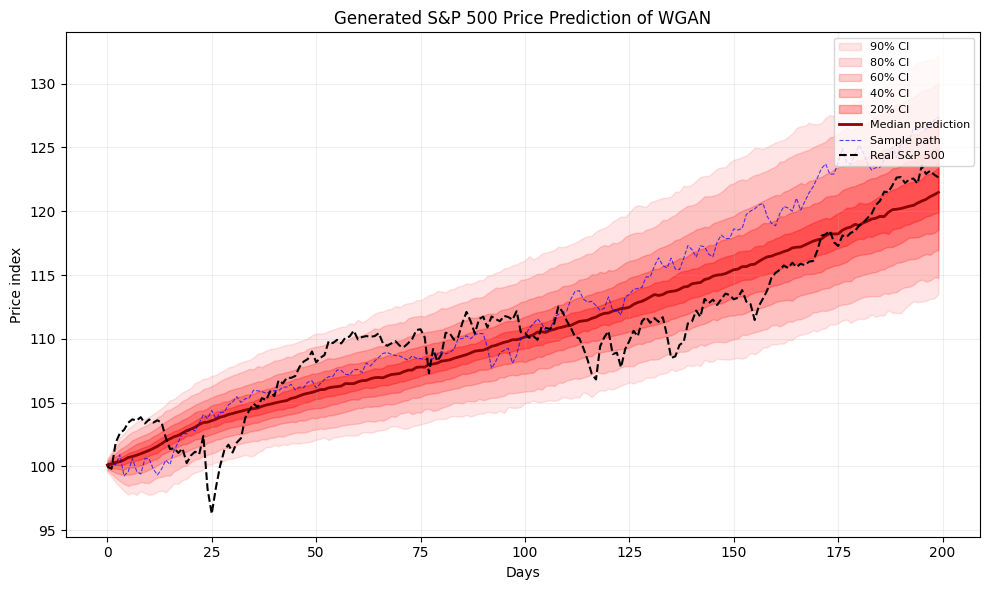

In [115]:
def returns_to_index_batch(returns, S0=100.0):
    returns = np.asarray(returns)
    if returns.ndim == 1:
        cum_ret = np.cumsum(returns)
        return S0 * np.exp(cum_ret)
    elif returns.ndim == 2:
        cum_ret = np.cumsum(returns, axis=1)
        return S0 * np.exp(cum_ret)


S0 = 100.0
T = SEQUENCE_LENGTH
N_SIM = NUM_SAMPLES_TO_GENERATE 

generator.eval()
with torch.no_grad():
    noise = torch.randn(N_SIM, T, NOISE_DIM, device=device)
    gen_norm = generator(noise).cpu().numpy()  

if gen_norm.ndim == 3:
    gen_norm = gen_norm.squeeze(-1) 

gen_norm_flat = gen_norm.reshape(-1, 1) 
gen_ret_flat = scaler.inverse_transform(gen_norm_flat)
gen_returns = gen_ret_flat.reshape(N_SIM, T) 
sim_prices = returns_to_index_batch(gen_returns, S0=S0)


close_all = data['Close'].dropna().values 
start_idx = 600   
end_idx = 800  
end_idx = min(end_idx, len(close_all))

real_close_seg = close_all[start_idx:end_idx] 
T_seg = len(real_close_seg)    

real_price = real_close_seg / real_close_seg[0] * S0 

sim_prices_seg = sim_prices[:, :T_seg] 
hist_index = close_all / close_all[0] * S0

percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
fan_data = np.percentile(sim_prices_seg, percentiles, axis=0) 

p5, p10, p20, p30, p40, p50, p60, p70, p80, p90, p95 = fan_data
x = np.arange(T_seg)

plt.style.use("default")

fig, ax2 = plt.subplots(figsize=(10, 6))

ax2.fill_between(x, p5,  p95, alpha=0.10, color="red", label="90% CI")
ax2.fill_between(x, p10, p90, alpha=0.15, color="red", label="80% CI")
ax2.fill_between(x, p20, p80, alpha=0.20, color="red", label="60% CI")
ax2.fill_between(x, p30, p70, alpha=0.25, color="red", label="40% CI")
ax2.fill_between(x, p40, p60, alpha=0.30, color="red", label="20% CI")
ax2.plot(x, p50, color="darkred", linewidth=2.0, label="Median prediction")

n_sample_paths = 1
n_sim = sim_prices_seg.shape[0]
indices = np.linspace(0, n_sim - 1, n_sample_paths, dtype=int)

for i, idx in enumerate(indices):
    sample_path = sim_prices_seg[idx]
    ax2.plot(
        x, sample_path,
        linewidth=0.8,
        linestyle="--",
        alpha=0.7,
        color="blue",
        label="Sample path" if i == 0 else None
    )

ax2.plot(
    x, real_price,
    linestyle="--",
    linewidth=1.5,
    color="black",
    label="Real S&P 500"
)

ax2.set_xlabel("Days")
ax2.set_ylabel("Price index")
ax2.set_title("Generated S&P 500 Price Prediction of WGAN")
ax2.grid(alpha=0.2)

handles, labels = ax2.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax2.legend(unique.values(), unique.keys(), loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()